# 3D Transforms

In this example we demonstrate 3D WarpAffine, Rotate and Resize

## Warp operators
All warp operators work by caclulating the output pixels by sampling the source image at transformed coordinates:

$${Out}(x, y, z) = {In}(x_{src}, y_{src}, z_{src})$$

This way each output pixel is calculated exactly once.

If the source coordinates do not point exactly to pixel centers, the values of neighboring pixels will be interpolated or the nearest pixel is taken, depending on the interpolation method specified in the `interp_type` argument.

### Affine transform

The source sample coordinates $x_{src}, y_{src}, z_{src}$ are calculated according to the formula:

$$
\begin{vmatrix}
x_{src} \\
y_{src} \\
z_{src}
\end{vmatrix}
= \begin{vmatrix}
m_{00} & m_{01} & m_{02} & t_x \\
m_{10} & m_{11} & m_{12} & t_y \\
m_{20} & m_{21} & m_{22} & t_z
\end{vmatrix}
\begin{vmatrix}
{x} \\
{y} \\
{z} \\
1
\end{vmatrix}
$$

Where $x, y$ are coordinates of the destination pixel and the matrix represents the inverse (destination to source) affine transform. The 
$\begin{vmatrix}
m_{00} & m_{01} & m_{02} \\
m_{10} & m_{11} & m_{12} \\
m_{20} & m_{21} & m_{22}
\end{vmatrix}$ block represents a combined rotate/scale/shear transform and $t_x, t_y, t_z$ is a translation vector.

### 3D Rotation

Rotate operator is implemented in terms of affine transform, but calculates the transform matrix internally. The output size is automatically adjusted and the size parity is adjusted to reduce blur near the volume centre. The rotation is defined by specifying axis (as a vector) and angle (in degrees).

The rotation matrix (source-to-destination) is calculated as:

$$
\begin{vmatrix}
u^2 + (v^2 + w^2) \cdot \cos \alpha &
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
uw\cdot(1-\cos \alpha) + v\cdot \sin \alpha \\
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
v^2 + (u^2 + w^2) \cdot \cos \alpha &
vw\cdot(1-\cos \alpha) - u\cdot \sin \alpha \\
uw\cdot(1-\cos \alpha) - v\cdot \sin \alpha &
vw\cdot(1-\cos \alpha + u\cdot \sin \alpha &
w^2 + (u^2 + w^2) \cdot \cos \alpha
\end{vmatrix}
$$

where $u, v, w$ is normalized `axis` vector and $\alpha$ is `angle` converted from degrees to radians.

Note that internally, the inverse matrix is used to achieve destination-to-source mapping, which is how the operation is actually implemented.

### 3D Resize

Resize for 3D is about the same as for 2D. Unlike Warp and Rotate, Resize supports a wider choice of resampling methods, many of which use anti-aliasing. For detailed description of Resize operator, see Resize tutorial.

## Usage example

First, let's import the necessary modules.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali.fn as fn
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools

Let's define some volumetric test data. The data consists of 3 surfaces, each drawn in a separate color plane (R,G,B).

In [2]:
nvidia_green = [0x76,0xb9,0x00]
violet = [0xff - 0x76, 0xff - 0xb9, 0xff]

def lerp(a, b, w):
    return a*(1-w)+b*w

def example_volume(shape):
    arr = np.zeros((*shape, 3))
    indices = np.array(list(itertools.product(*[range(x) for x in shape]))).reshape((*shape, len(shape)))
    
    size = np.array([[[list(shape)]]])
    coords = (indices - size/2) * (2 / size)
    X = coords[:,:,:,2]
    Y = coords[:,:,:,1]
    Z = coords[:,:,:,0]
    surface1 = 2*Z*Z + 2*Y*Y - np.exp(-X*X*3)
    surface2 = X*X + Y*Y + Z*Z - 0.2
    surface3 = 2*Z*Z + 2*X*X - np.exp(-Y*Y*2)
    arr[:,:,:,0] = (1 - abs(surface1)*8).clip(0, 1)
    arr[:,:,:,1] = (1 - abs(surface2)*20).clip(0, 1)
    arr[:,:,:,2] = (1 - abs(surface3)*8).clip(0, 1)
    # force 0 at boundary
    arr[0,:,:,:] = 0
    arr[-1,:,:,:] = 0
    arr[:,0,:,:] = 0
    arr[:,-1,:,:] = 0
    arr[:,:,0,:] = 0
    arr[:,:,-1,:] = 0
    
    return (arr*255).clip(0,255).astype(np.uint8)

def GetData():
    return [example_volume([128,128,128])]

Now, let's define the pipeline. The transform parameters are hard-coded, but axis, angle and matrix arguments can be specified as CPU tensors. The warp matrices can alternatively be passed as a regular input to the WarpAffine operator, in which case they can be passed as a GPU tensor.
See Warp example for exact usage.

In [3]:
pipe = Pipeline(batch_size = 1, num_threads = 3, device_id = 0, exec_pipelined = True, exec_async = True)
with pipe:
    data = fn.external_source(source=GetData, device="gpu", layout="DHWC")
       
    angle = fn.uniform(range=(-180, 180))
    axis = fn.uniform(range=(-1,1), shape=[3])
    rotated = fn.rotate(
            data,
            angle = angle,
            axis = axis,
            interp_type = types.INTERP_LINEAR
        )

    warped = fn.warp_affine(
            data,
            size = (128, 128, 200),
            matrix = (
                1, 1, 0,   -60,
                0, 1, 0.2, -20,
                0, 0, 1,   10
            ),
            interp_type = types.INTERP_LINEAR
        )
    
    resized = fn.resize(
            data,
            size = (50, 75, 100),
            roi_start = (0, 0, 0),
            roi_end = (0.5, 0.75, 1),
            roi_relative = True,
            interp_type = types.INTERP_LANCZOS3
        )
        
    pipe.set_outputs(data, rotated, warped, resized, axis, angle)

pipe.build()


Finally, we can run our pipeline to obtain the preprocessed volumes.

In [4]:
pipe_out = pipe.run()

## Example output

The output is displayed as three middle slices (XY, ZY and XZ) and a perspective projection.
The perspective projection is obtained by summing intensities along rays corresponding to pixels.

In [5]:
import cv2
    
def centered_scale(in_size, out_size, scale):
    tx = (in_size[1]-out_size[1]/scale)/2
    ty = (in_size[0]-out_size[0]/scale)/2
    return np.array([[1/scale, 0, tx],
                     [0, 1/scale, ty]])

def project_volume(volume, out_size, eye_z, fovx = 90, zstep = 0.25):
    output = np.zeros(out_size + [volume.shape[-1]])
    in_size = volume.shape[1:3]
    fovx_z = math.tan(math.radians(fovx/2)) * volume.shape[2] / out_size[1]

    def project_slice(volume, plane_z):
        plane_index = int(plane_z)
        volume_slice = volume[plane_index]
        scale = volume_slice.shape[1] / fov_w
        M = centered_scale(in_size, out_size, scale)
        return cv2.warpAffine(volume_slice, M,
                              dsize = (out_size[1], out_size[0]),
                              flags = cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR)

    for plane_z in np.arange(0, volume.shape[0], zstep):
        z = plane_z - eye_z
        fov_w = z * fovx_z
        z0 = np.clip(math.floor(plane_z), 0, volume.shape[0]-1)
        z1 = np.clip(math.ceil(plane_z), 0, volume.shape[0]-1)
        projected_slice = project_slice(volume, z0)
        # trilinear interpolation
        if z1 != z0:
            slice1 = project_slice(volume, z1)
            q = (plane_z - np.floor(plane_z))
            projected_slice = (projected_slice * (1-q) + slice1*q).astype(np.uint8)

        #np.maximum(output, projected_slice, out = output)
        output += projected_slice

    return output

def perspective(volume, max_size):
    window_size = 300
    (h, w) = volume.shape[1:3]
    if h > w:
        w = window_size * w // h
        h = window_size
    else:
        h = window_size * h // w
        w = window_size
    return (project_volume(volume, [h,w], -volume.shape[2]) * (1 / 255.0))

import matplotlib.gridspec as gridspec

len_outputs = len(pipe_out)

def draw_volume(volume, title):
    captions = ["XY middle slice", "ZY middle slice", "XZ middle slice", "perspective"]
    shape = volume.shape
    persp = perspective(volume, 300)
    persp *= 1.0/persp.max()
    persp = persp.clip(0, 1)
    
    images = [volume[shape[0]//2,:,:,:],
              volume[:,:,shape[2]//2,:].transpose((1,0,2)),
              volume[:,shape[1]//2,:,:],
              persp]

    fig = plt.figure(figsize = (16,18))
    plt.suptitle(title, fontsize=18)
    columns = 2
    rows = int(math.ceil(len(images) / columns))
    gs = gridspec.GridSpec(rows, columns)

    for i in range(len(images)):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(captions[i])
        plt.imshow(images[i], origin='lower')

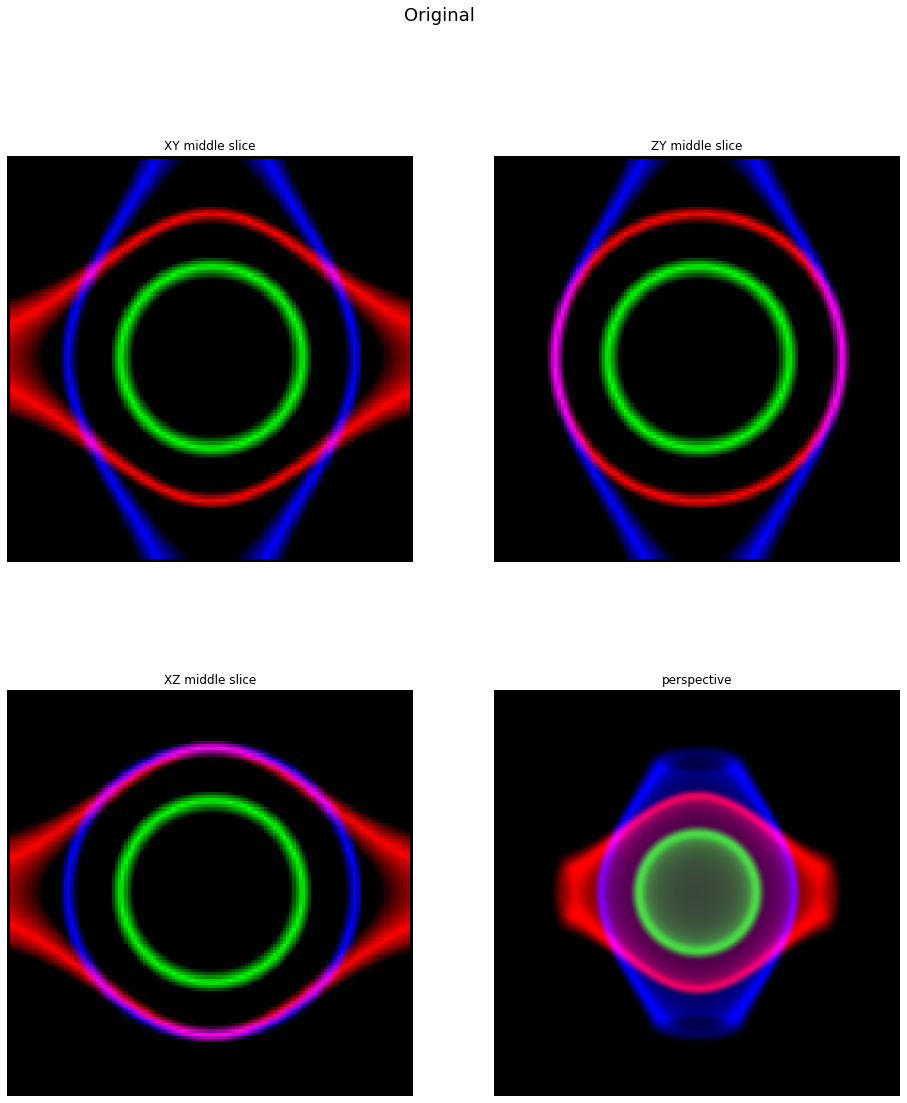

In [6]:
draw_volume(pipe_out[0].as_cpu().at(0), "Original")

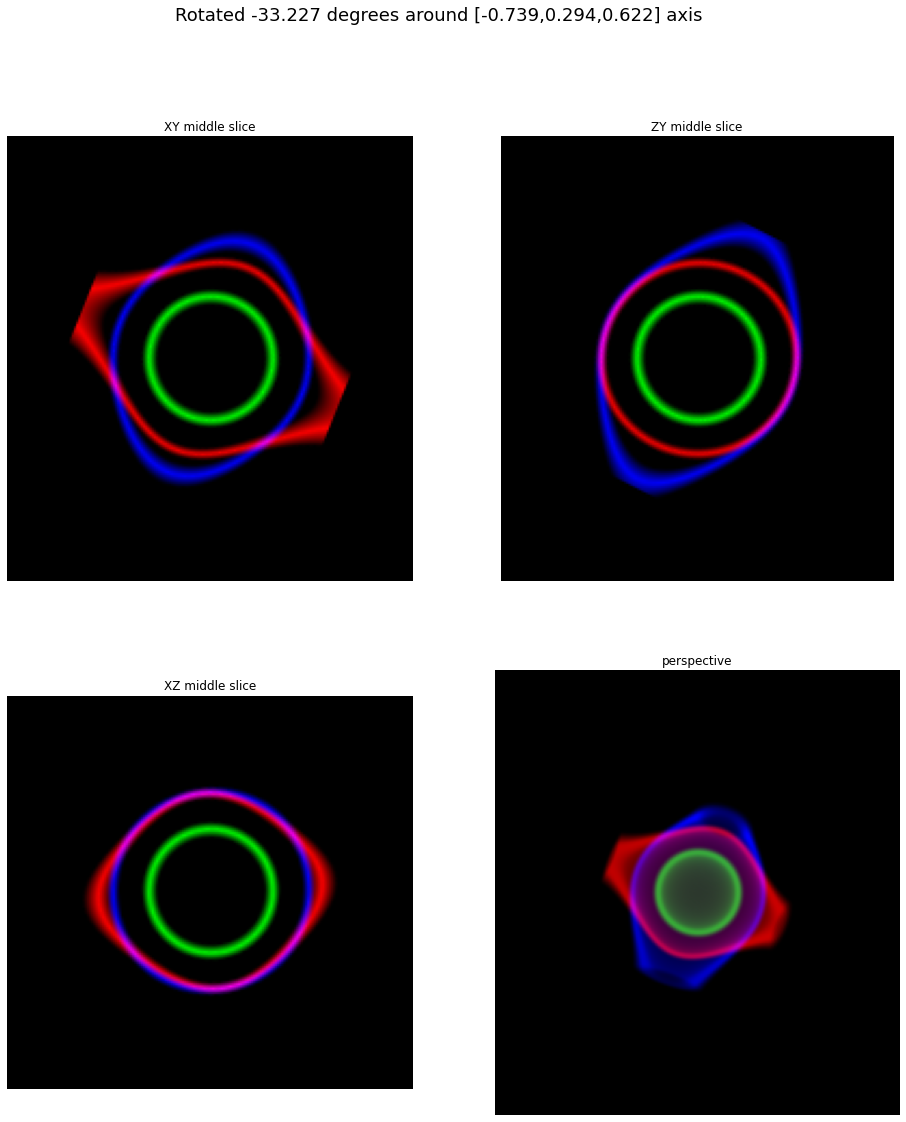

In [7]:
angle = pipe_out[-1].at(0)[0]
axis = pipe_out[-2].at(0).tolist()
draw_volume(pipe_out[1].as_cpu().at(0), "Rotated {:.3f} degrees around [{:.3},{:.3},{:.3}] axis".format(angle, axis[0], axis[1], axis[2]))

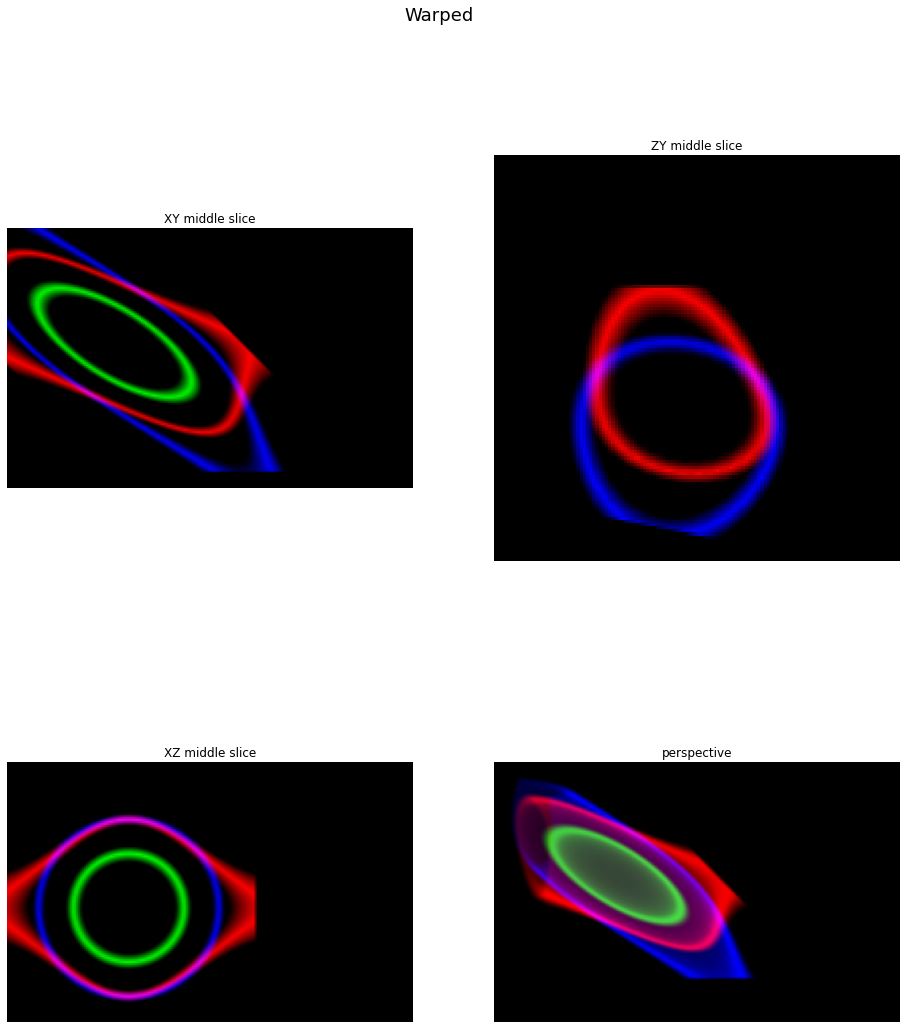

In [8]:
draw_volume(pipe_out[2].as_cpu().at(0), "Warped")

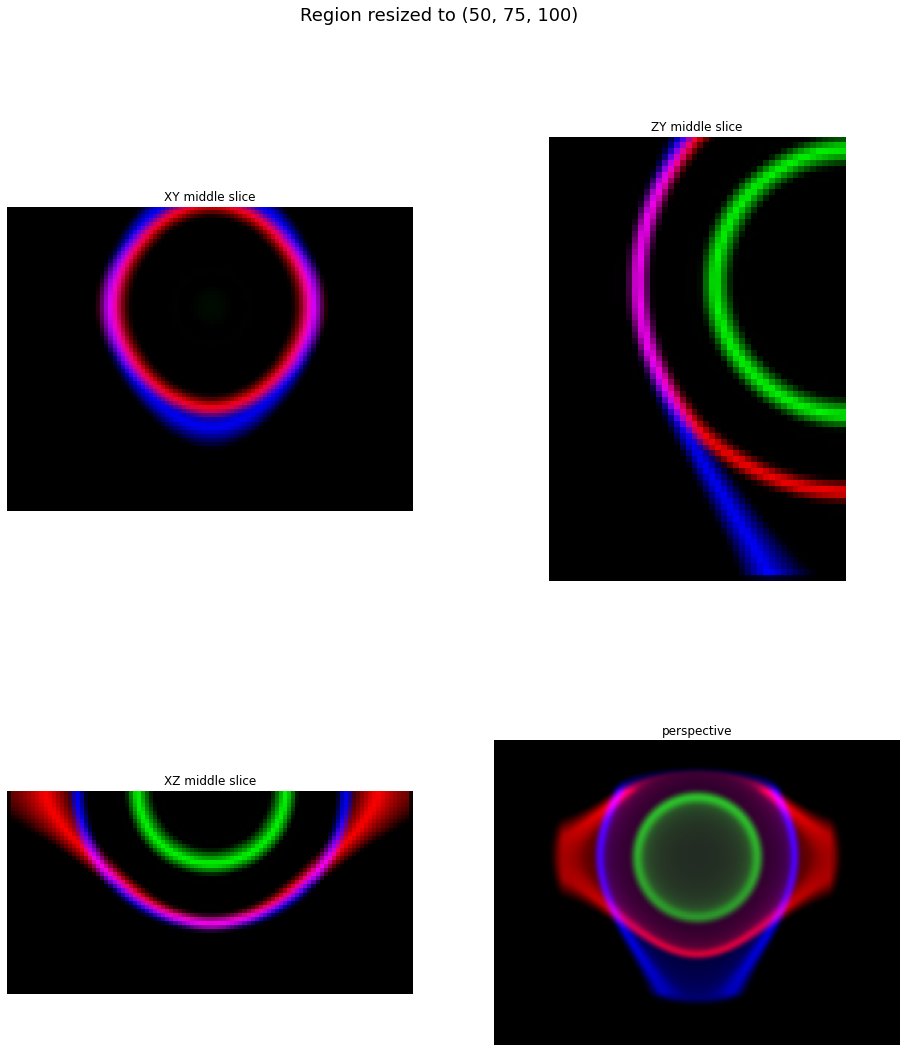

In [9]:
vol = pipe_out[3].as_cpu().at(0)
draw_volume(vol, "Region resized to {}".format(vol.shape[:-1]))